<a href="https://colab.research.google.com/github/Oktaviani30/DeepLearningLanjut/blob/main/1stWeekTasksDeep_Learning_Lanjut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda
Content image size: torch.Size([1, 3, 512, 512])
Style image size: torch.Size([1, 3, 512, 512])


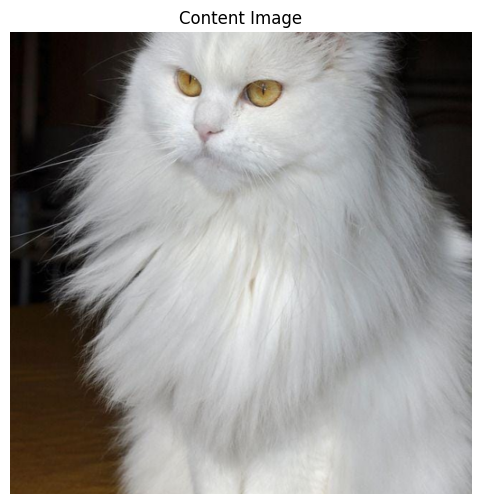

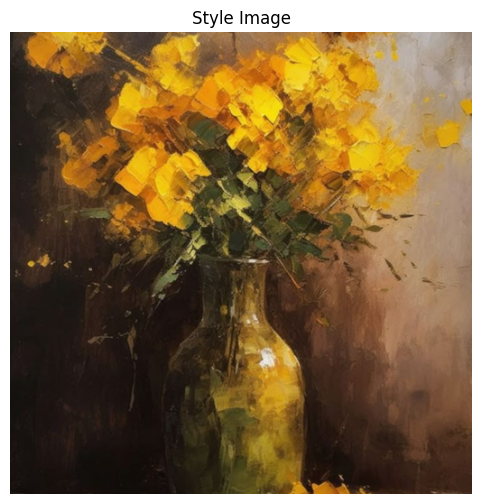

/tmp/ipython-input-2248589314.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).clone().detach().view(-1,1,1)
/tmp/ipython-input-2248589314.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).clone().detach().view(-1,1,1)


num_steps: 500  style_weight: 1000000.0  content_weight: 10
Run 1: Style Loss : 1445.743896 Content Loss: 0.000000
Run 50: Style Loss : 107.075317 Content Loss: 57.709023
Run 100: Style Loss : 54.804836 Content Loss: 42.019768
Run 150: Style Loss : 37.442619 Content Loss: 40.282917
Run 200: Style Loss : 25.557711 Content Loss: 38.443047
Run 250: Style Loss : 18.023058 Content Loss: 35.626595
Run 300: Style Loss : 11.645384 Content Loss: 34.088585
Run 350: Style Loss : 7.844077 Content Loss: 33.224709
Run 400: Style Loss : 5.736542 Content Loss: 32.592499
Run 450: Style Loss : 4.664151 Content Loss: 32.324085
Run 500: Style Loss : 4.096388 Content Loss: 32.242226


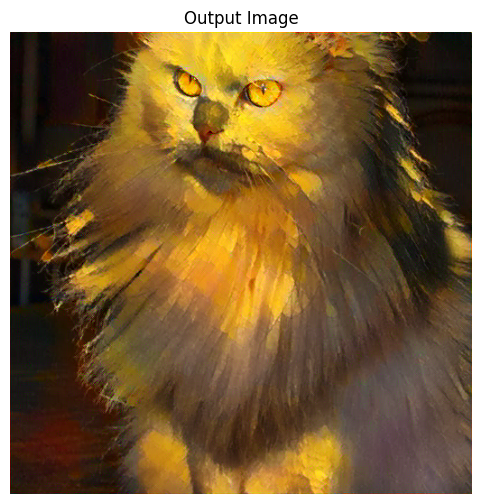

Hasil disimpan di: /content/drive/MyDrive/Colab Notebooks/Semester 6/Deep Learning Lanjut/nst_output.jpg


In [6]:
# Neural Style Transfer (Natural style transfer) - Colab-ready
# Posisi Anda: pakar penelitian computer vision & pakar koding Python di Google Colab
# File ini siap dijalankan di Google Colab. Gunakan runtime GPU (Runtime -> Change runtime type -> GPU).

#@title Persiapan: mounts, import, dan path gambar { display-mode: "form" }
from google.colab import drive
drive.mount('/content/drive')

# Ganti/cek path berikut sesuai yang Anda sebutkan (sudah diset otomatis):
content_img_path = "/content/drive/MyDrive/Colab Notebooks/Semester 6/Deep Learning Lanjut/WhatsApp Image 2025-11-26 at 22.44.04.jpeg"
style_img_path   = "/content/drive/MyDrive/Colab Notebooks/Semester 6/Deep Learning Lanjut/WhatsApp Image 2025-11-26 at 22.52.39.jpeg"
#@markdown Jika ingin menukar content/style, ubah nilai variabel di atas.

#@title Imports dan pengecekan device
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

#@title Fungsi utilitas: load image, imshow, save
imsize = 512 if torch.cuda.is_available() else 256  # ukuran default

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()
])

unloader = transforms.ToPILImage()


def load_image(image_path, transform=loader, device=device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)


def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(image)
    plt.show()

#@title Muat gambar content & style
content_img = load_image(content_img_path)
style_img = load_image(style_img_path)
print('Content image size:', content_img.shape)
print('Style image size:', style_img.shape)

# Tampilkan preview
imshow(content_img, title='Content Image')
imshow(style_img, title='Style Image')

#@title Model: VGG19 (pretrained) dan ekstraksi fitur
cnn = models.vgg19(pretrained=True).features.to(device).eval()
# Normalization values dari ImageNet
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Lapisan yang akan dipakai sebagai content dan style
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Normalization module
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view to make [C] -> [1,C,1,1]
        self.mean = torch.tensor(mean).clone().detach().view(-1,1,1)
        self.std = torch.tensor(std).clone().detach().view(-1,1,1)

    def forward(self, img):
        return (img - self.mean) / self.std

# Gram matrix untuk style representation
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        features = input.view(b * c, h * w)
        G = torch.mm(features, features.t())
        # normalisasi
        return G.div(b * c * h * w)

# Feature extraction: buat model baru yang mengembalikan features dari layer terpilih

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                 style_img, content_img,
                                 content_layers=content_layers_default,
                                 style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # hitung conv layer
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # ganti inplace ReLU agar bisa dapat grad
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            name = 'layer_{}'.format(i)

        model.add_module(name, layer)

        if name in content_layers:
            # tambahkan content loss
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # tambahkan style loss
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # memotong model setelah loss terakhir
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses

# Loss modules
def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = 0

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = 0

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

#@title Setup model dan loss
model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                 cnn_normalization_mean,
                                                                 cnn_normalization_std,
                                                                 style_img, content_img)

#@title Inisialisasi gambar input (copy content) dan optimizer
input_img = content_img.clone()
# alternatif: noise
# input_img = torch.randn(content_img.data.size(), device=device)

# Buat parameter yang dapat dioptimalkan
input_img.requires_grad_(True)

# Pengaturan optimizer
optimizer = optim.LBFGS([input_img])

#@title Parameter pelatihan (ubah jika perlu) { display-mode: "form" }
num_steps = 500         #@param {type: "integer"}
style_weight = 1e6      #@param {type: "number"}
content_weight = 10      #@param {type: "number"}
print('num_steps:', num_steps, ' style_weight:', style_weight, ' content_weight:', content_weight)

#@title Run style transfer
run = [0]
while run[0] <= num_steps:

    def closure():
        input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0 or run[0] == 1 or run[0] == num_steps:
            print("Run {}: Style Loss : {:4f} Content Loss: {:4f}".format(run[0],
                                                                          style_score.item(),
                                                                          content_score.item()))
        return style_score + content_score

    optimizer.step(closure)

# perkecil ke rentang pixel valid
input_img.data.clamp_(0, 1)

# Tampilkan hasil
imshow(input_img, title='Output Image')

#@title Simpan hasil ke Google Drive
output_save_path = "/content/drive/MyDrive/Colab Notebooks/Semester 6/Deep Learning Lanjut/nst_output.jpg"
output_image = input_img.cpu().clone().squeeze(0)
output_pil = unloader(output_image)
output_pil.save(output_save_path)
print(f"Hasil disimpan di: {output_save_path}")

#@title Catatan singkat
# - Jika ingin hasil lebih natural: gunakan content_weight lebih besar dan style_weight lebih kecil, atau gunakan fewer style layers.
# - Untuk eksperimen gaya natural: coba kombinasi style_layers yang lebih rendah (misal conv_1 sampai conv_3) dan atur style_weight ke 1e5 - 5e5.
# - Untuk kualitas lebih tinggi: ubah imsize ke 768 (but GPU memory heavy).
# - Jika ingin menyimpan intermediate frames, tambahkan kode di closure() untuk menyimpan tiap N iterasi.

# Selesai. Jalankan sel demi sel pada Google Colab. Selamat bereksperimen!